### Analysing points of lucky escapes using FCD, OSM & Accident data For the city of Hamburg

In [1]:
%load_ext autoreload
%autoreload 2
# load dependencies
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import folium 
import seaborn as sns
import osmnx as ox
import networkx as nx
import pyproj
import math 
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import pysal 
from pysal import esda
#import libpysal #added
pd.options.mode.chained_assignment = None 
#from pysal.explore import esda
from pyproj import CRS
from pyproj import Transformer
from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
#Hamburg Bounding box
bbox = BboxSelector([
    9.918594360351562, # min_x
    53.50315910192688, # min_y
    10.110855102539062, # max_x
    53.59291234778207  # max_y
])

#issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=150) # requesting 150 tracks inside the bbox
#display output
track_df

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,GPS Speed.value,GPS Speed.unit,GPS Altitude.value,...,O2 Lambda Current ER.value,O2 Lambda Current ER.unit,O2 Lambda Current.value,O2 Lambda Current.unit,track.appVersion,track.touVersion,Long-Term Fuel Trim 1.value,Long-Term Fuel Trim 1.unit,Short-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.unit
0,5cdcea6d44ea85030283f9df,2019-04-15T07:57:44,POINT (7.62735 51.80645),2.3,%,0.336020,ratio,134.906554,km/h,63.912372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5cdcea6d44ea85030283f9e1,2019-04-15T07:57:49,POINT (7.62600 51.80786),2.2,%,0.138903,ratio,130.448702,km/h,65.513918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5cdcea6d44ea85030283f9e2,2019-04-15T07:57:54,POINT (7.62462 51.80922),2.1,%,0.090592,ratio,132.323921,km/h,66.223409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5cdcea6d44ea85030283f9e3,2019-04-15T07:57:59,POINT (7.62314 51.81063),2.0,%,0.132368,ratio,133.438745,km/h,66.612251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5cdcea6d44ea85030283f9e4,2019-04-15T07:58:04,POINT (7.62164 51.81202),2.0,%,0.162579,ratio,132.869762,km/h,67.179196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,53f20f74e4b0d0547747de5d,2014-06-08T16:05:57,POINT (9.28521 53.19534),4.0,%,NaN,NaN,44.100000,km/h,65.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,7.03125,%,2.34375,%
1127,53f20f74e4b0d0547747de5f,2014-06-08T16:06:03,POINT (9.28605 53.19585),8.0,%,NaN,NaN,47.700000,km/h,67.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,10.15625,%,5.46875,%
1128,53f20f74e4b0d0547747de61,2014-06-08T16:06:09,POINT (9.28683 53.19621),5.0,%,NaN,NaN,31.500000,km/h,69.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.37500,%,7.03125,%
1129,53f20f74e4b0d0547747de63,2014-06-08T16:06:15,POINT (9.28731 53.19595),5.0,%,NaN,NaN,30.600000,km/h,68.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,4.68750,%,2.34375,%


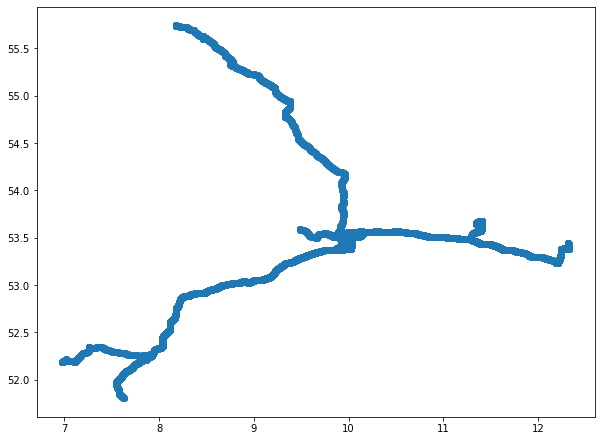

In [3]:
#Track plot
track_df.plot(figsize=(10, 12))

In [4]:
#dataframe details
track_df.describe()

,GPS Accuracy.value,O2 Lambda Voltage ER.value,GPS Speed.value,GPS Altitude.value,Engine Load.value,GPS Bearing.value,Speed.value,Intake Pressure.value,Intake Temperature.value,Throttle Position.value,...,track.length,sensor.engineDisplacement,sensor.constructionYear,Consumption.value,Calculated MAF.value,CO2.value,O2 Lambda Current ER.value,O2 Lambda Current.value,Long-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.value
count,27372.000000,2043.000000,27372.000000,27372.000000,9320.000000,26648.000000,25008.000000,25008.000000,24966.000000,9320.000000,...,27372.000000,27372.000000,27372.000000,6263.000000,21949.000000,6263.000000,1015.000000,1015.000000,5772.000000,5772.000000
mean,6.768645,0.340696,101.053389,77.614779,40.672293,175.627977,102.546225,75.770110,89.796913,47.679715,...,170.036993,1770.166484,2010.543073,10.891273,19.697738,25.594492,1.663868,-7.257891,-0.452075,0.208036
std,3.851232,0.559808,37.880169,31.715651,25.723145,103.954156,36.624245,40.933209,66.655859,29.958889,...,201.375507,367.192439,4.111629,7.362146,13.319433,17.301044,0.324491,67.313416,6.011252,2.623296
min,1.500000,0.059025,-308.447929,-24.651999,0.000000,-370.999985,0.000000,10.000000,1.000000,5.000000,...,0.000000,1598.000000,2003.000000,0.834954,0.000000,1.962142,0.985220,-127.662640,-13.281250,-14.062500
25%,3.000000,0.097378,83.091004,62.000000,18.431372,79.000000,85.000000,45.000000,15.000000,24.000000,...,0.000000,1600.000000,2011.000000,4.769779,10.912204,11.208980,1.432639,-64.083505,-4.687500,-1.562500
50%,5.000000,0.112489,112.500000,79.000000,39.585889,190.300003,113.000000,73.000000,89.000000,36.000000,...,0.000000,1600.000000,2011.000000,9.601972,16.516891,22.564634,1.702778,-10.466729,-2.343750,0.000000
75%,10.000000,0.179301,126.900000,91.099976,61.535868,272.200012,127.000000,88.000000,151.000000,84.000003,...,450.813642,1968.000000,2014.000000,16.557731,23.640526,38.910669,1.999969,47.814893,3.906250,1.562500
max,51.000000,1.999939,254.848383,200.299988,100.000003,359.772995,250.753333,255.000008,209.000000,98.000000,...,450.813642,4163.000000,2014.000000,89.647054,272.713807,210.670576,1.999970,106.371704,16.406250,13.281250


In [5]:
#sorting by the track id
track_df.groupby(track_df['track.id']).count()

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,GPS Speed.value,GPS Speed.unit,GPS Altitude.value,...,O2 Lambda Current ER.value,O2 Lambda Current ER.unit,O2 Lambda Current.value,O2 Lambda Current.unit,track.appVersion,track.touVersion,Long-Term Fuel Trim 1.value,Long-Term Fuel Trim 1.unit,Short-Term Fuel Trim 1.value,Short-Term Fuel Trim 1.unit
track.id,,,,,,,,,,,,,,,,,,,,,
53f20f6ee4b0d0547747d58f,1131,1131,1131,1131,1131,0,0,1131,1131,1131,...,0,0,0,0,0,0,1131,1131,1131,1131
54f76d4ae4b0bf5f3ce07ee9,2333,2333,2333,2333,2333,0,0,2333,2333,2333,...,0,0,0,0,2333,2333,0,0,0,0
54f797c5e4b0bf5f3ce13e1f,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f7987ee4b0bf5f3ce19fbb,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f7996ee4b0bf5f3ce20157,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79b67e4b0bf5f3ce265d3,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79cd6e4b0bf5f3ce2e382,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79df0e4b0bf5f3ce3451e,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0
54f79f39e4b0bf5f3ce3a6ba,834,834,834,834,834,0,0,834,834,834,...,0,0,0,0,834,834,0,0,0,0


,id,track.id,time,lat,lng,speed,year,month,spddiff
0,5cdcea6d44ea85030283f9df,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:44,51.806449,7.627348,134.906554,2019,4,0.000000
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,-4.457852
2,5cdcea6d44ea85030283f9e2,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:54,51.809224,7.624619,132.323921,2019,4,1.875219
3,5cdcea6d44ea85030283f9e3,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:59,51.810633,7.623141,133.438745,2019,4,1.114824
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984


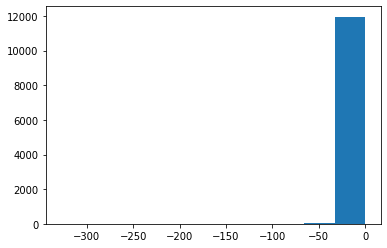

In [6]:
#Calculating the speed difference at points
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
track_df['speed'] = track_df['GPS Speed.value']
track_df['time_year'] = pd.to_datetime(track_df['time'], format = "%Y-%m")
track_df['year'] = track_df['time_year'].dt.year
track_df['month'] = track_df['time_year'].dt.month

#Creating a new subset of the data
data_df = track_df[['id','track.id','time','lat','lng','speed','year','month']]
speed = data_df['speed']

#Calculating speed different between points
spd_list = []
index = 0
for cal in speed:
    currspd = cal
    if index > 0:
        diff = currspd - prvspd
        spd_list.append(diff)
    else:
        spd_list.append(0)
    prvspd = currspd
    index += 1


data_df['spddiff']= spd_list
neg_speed = data_df[data_df['spddiff']<0]  #de-accelaration points

#plot data
plt.hist(neg_speed['spddiff'])

#displaying output
data_df.head()

In [7]:
#mean reduction on speed on track
np.mean(neg_speed['spddiff'])

-4.159518325725712

In [8]:
#making a function to color based on speed difference
def colors(array):
    col = []
    for value in array:
        if value < 0 and value > -5:
            col.append('yellow')
        elif value < -5 and value > -20:
            col.append('green')
        else:
            col.append('red')
    return col

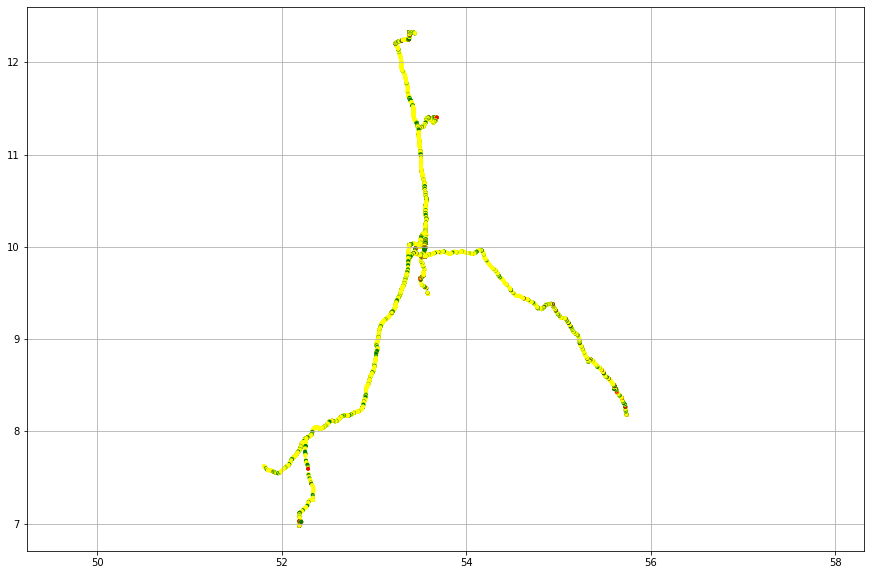

In [9]:
#plotting the tracks based on the reduction in speed
cols = colors(neg_speed['spddiff'])
f,axxarr = plt.subplots(1, figsize = (15,10))   
axxarr.scatter(neg_speed['lat'], neg_speed['lng'], c=cols, cmap='Accent', s=15, lw=0)

plt.axis('equal')
axxarr.grid(True)
plt.show()

In [10]:
#making a subset of the data with negative data only
neg_data = data_df[data_df['spddiff'] < 0]
neg_data

,id,track.id,time,lat,lng,speed,year,month,spddiff
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,-4.457852
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984
7,5cdcea6d44ea85030283f9e7,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:19,51.816179,7.616924,137.473462,2019,4,-1.024269
8,5cdcea6d44ea85030283f9e8,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:24,51.817553,7.615308,137.375204,2019,4,-0.098259
9,5cdcea6d44ea85030283f9e9,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:29,51.818925,7.613679,135.989828,2019,4,-1.385375
...,...,...,...,...,...,...,...,...,...
1123,53f20f74e4b0d0547747de57,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:39,53.195092,9.287005,71.100000,2014,6,-26.100000
1124,53f20f74e4b0d0547747de59,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:45,53.194573,9.286022,45.900000,2014,6,-25.200000
1125,53f20f74e4b0d0547747de5b,53f20f6ee4b0d0547747d58f,2014-06-08T16:05:51,53.194776,9.285114,39.600000,2014,6,-6.300000
1128,53f20f74e4b0d0547747de61,53f20f6ee4b0d0547747d58f,2014-06-08T16:06:09,53.196214,9.286828,31.500000,2014,6,-16.200000


In [11]:
#identify first record in each track and adding a default value of 0
tracks_id = (neg_data['id'].groupby(neg_data['track.id']).nth(0)).tolist()
neg_data['spddiff'][neg_data['id'].isin(tracks_id)] = 0

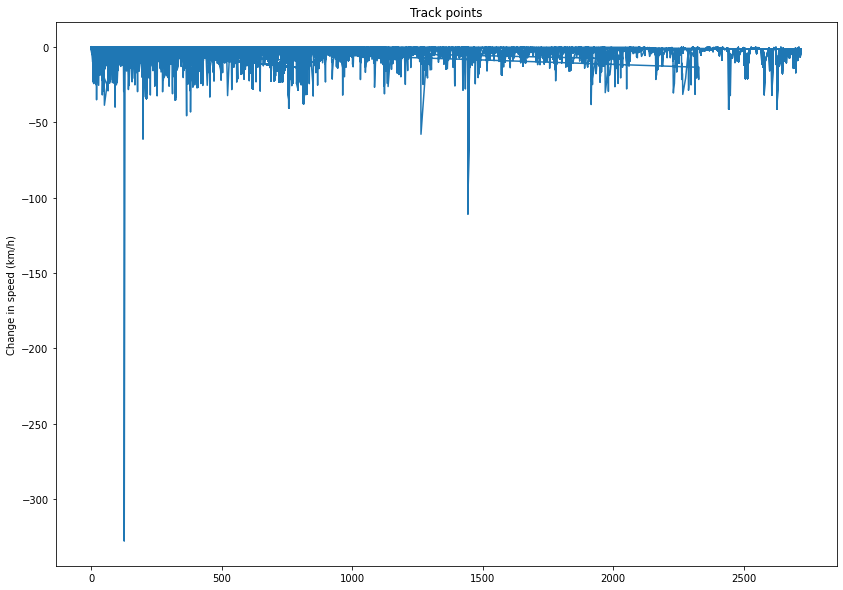

In [12]:
#plotting the change in speed
ax = neg_data['spddiff'].plot(figsize= (14, 10))
ax.set_title("Track points")
ax.set_ylabel("Change in speed (km/h)")
ax        

In [13]:
#adding colors to the points based on speed reduction using the colors function above
cols_some = colors(neg_data['spddiff'])
print(len(cols_some))
cols_some.pop()
len(cols_some)

12005


12004

### Mapping Points of Speed Reduction

In [14]:
#plotting points on a map using folium
lats = list(neg_data['lat'])
lngs = list(neg_data['lng'])
speed = list(neg_data['spddiff']) 
speedactual = list(neg_data['speed'])
avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
def popfn(popa, popb):
    return('Speed Difference is: '+ str(round(popa, 2))+ 'Km/h'+'\n Actual speed is:' + str(round(popb, 2))+'Km/h')

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=8)
for lat, lng , col, pop,pop1 in zip(lats,lngs, cols_some, speed, speedactual ):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = popfn(pop, pop1)).add_to(m)
m.save('DecelarationPointsHamburg.html')

## Downloading OSM Data for Hamburg

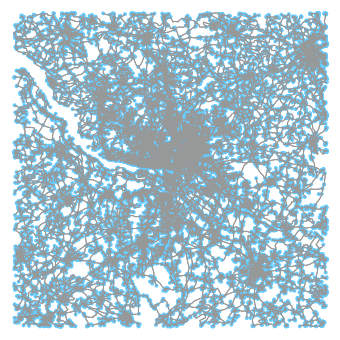

(<Figure size 726.521x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a38a69510>)

In [15]:
#downloading road netwrok from osmnx
G = ox.graph_from_point((53.54, 10.00), dist=50000, network_type='drive')
ox.plot_graph(G)

In [16]:
#exploring the data frame
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.columns

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'maxspeed', 'lanes', 'ref', 'bridge', 'junction', 'access',
       'width', 'tunnel', 'service', 'est_width'],
      dtype='object')

In [17]:
#checking the speed limits on osm data
print(edges['maxspeed'].value_counts())

30                     79123
50                     49627
70                      2653
100                     2621
[50, 30]                1677
                       ...  
[50, 30, 70, 100]          1
[30, 40]                   1
[50, 100, 30, 10]          1
[60, 40, 100]              1
[60, 80, none, 100]        1
Name: maxspeed, Length: 137, dtype: int64


In [18]:
#exploring the edges in osm network
edges.head()

,u,v,key,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width
0,275251200,275251201,0,25258883,Glosterstraße,residential,False,39.780,"LINESTRING (9.67039 53.52337, 9.67026 53.52336...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275251200,275251199,0,25258883,Glosterstraße,residential,False,87.301,"LINESTRING (9.67039 53.52337, 9.67105 53.52315...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275251200,601508668,0,25258891,Glosterstraße,residential,False,54.662,"LINESTRING (9.67039 53.52337, 9.67048 53.52346...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,114294785,114294813,0,12541941,Schwalbenweg,residential,False,140.181,"LINESTRING (10.22896 53.95189, 10.22842 53.951...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114294785,114294789,0,18959076,Alte Landstraße,residential,False,132.630,"LINESTRING (10.22896 53.95189, 10.22964 53.951...",30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#reprojecting the OSM data to projected crs and applying a buffer
prjedge = edges.to_crs('EPSG:25832')
prjedge['geometry'] = prjedge.geometry.buffer(5)
prjedge.head()

,u,v,key,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width
0,275251200,275251201,0,25258883,Glosterstraße,residential,False,39.780,"POLYGON ((544435.797 5930697.037, 544435.266 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,275251200,275251199,0,25258883,Glosterstraße,residential,False,87.301,"POLYGON ((544490.405 5930683.219, 544490.779 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,275251200,601508668,0,25258891,Glosterstraße,residential,False,54.662,"POLYGON ((544444.851 5930714.519, 544448.735 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,114294785,114294813,0,12541941,Schwalbenweg,residential,False,140.181,"POLYGON ((580619.713 5978777.261, 580614.338 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,114294785,114294789,0,18959076,Alte Landstraße,residential,False,132.630,"POLYGON ((580696.793 5978841.757, 580696.834 5...",30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Converting the deceleration data to a dataframe and reprojecting to a projected CRS
neg_gdf = gpd.GeoDataFrame(
    neg_data, geometry=gpd.points_from_xy(neg_data.lng, neg_data.lat),crs="EPSG:4326")
neg_gdf = neg_gdf.to_crs('EPSG:25832')
neg_gdf.head()

,id,track.id,time,lat,lng,speed,year,month,spddiff,geometry
1,5cdcea6d44ea85030283f9e1,5cdcea6d44ea85030283f9dd,2019-04-15T07:57:49,51.807855,7.626002,130.448702,2019,4,0.000000,POINT (405273.087 5740560.439)
4,5cdcea6d44ea85030283f9e4,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:04,51.812016,7.621639,132.869762,2019,4,-0.568984,POINT (404981.069 5741028.881)
7,5cdcea6d44ea85030283f9e7,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:19,51.816179,7.616924,137.473462,2019,4,-1.024269,POINT (404664.817 5741498.007)
8,5cdcea6d44ea85030283f9e8,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:24,51.817553,7.615308,137.375204,2019,4,-0.098259,POINT (404556.337 5741652.922)
9,5cdcea6d44ea85030283f9e9,5cdcea6d44ea85030283f9dd,2019-04-15T07:58:29,51.818925,7.613679,135.989828,2019,4,-1.385375,POINT (404446.968 5741807.576)


In [21]:
#Joinig the buffered OSM data with deceleration data
neg_gdf_join_osmedge = gpd.sjoin(neg_gdf, prjedge, op='intersects')
len(neg_gdf_join_osmedge)

3912

In [22]:
#Sorting to get the minimum speed limit on roads with more than one speed limit 
def getMin(inp):
    min = 10000  #defining a high value 
    for i in inp:
        if i < min:
            min = i
    return min
        

In [23]:
#Sorting the speed limits
#in case there is more than one speed limit in an edge and also places with no speed limit
#no speed limit will be substituted with 130 km/h based on literature
#for edges with 2 or more speed limits the lower value is considered
speed_lst = []
for m in neg_gdf_join_osmedge['maxspeed']:
    if (type(m) ==str and len(m) <= 3):
        speed_lst.append(int(m))
    elif type(m) == list:
        conv = []
        for n in m:
            try:
                conv.append(int(n))
            except ValueError:
                conv.append(130)
        speed_lst.append(getMin(conv))        
        
    else:
        speed_lst.append(130)
            
print(speed_lst)   

[130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,

In [24]:
#Removing columns that are not needed
neg_gdf_join_osmedge['spdlimit'] = speed_lst
neg_gdf_join_osmedge_new = neg_gdf_join_osmedge[['track.id', 'lat', 'lng', 'speed', 'spddiff', 'geometry', 'spdlimit','year', 'month']]
neg_gdf_join_osmedge_new

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month
1437,5cdcea6d44ea85030283f9dd,53.194387,9.286511,126.168509,-0.850732,POINT (519141.345 5893933.126),130,2019,4
1438,5cdcea6d44ea85030283f9dd,53.195467,9.288158,124.246488,-1.922021,POINT (519250.890 5894053.716),130,2019,4
1441,5cdcea6d44ea85030283f9dd,53.198920,9.293395,124.437444,-1.399528,POINT (519599.204 5894439.246),130,2019,4
1443,5cdcea6d44ea85030283f9dd,53.201220,9.296888,122.281555,-2.873144,POINT (519831.456 5894696.071),130,2019,4
1444,5cdcea6d44ea85030283f9dd,53.202338,9.298588,121.596220,-0.685336,POINT (519944.507 5894820.979),130,2019,4
...,...,...,...,...,...,...,...,...,...
877,53f20f6ee4b0d0547747d58f,53.384716,10.019206,60.300000,-1.800000,POINT (567788.744 5915552.382),80,2014,6
895,53f20f6ee4b0d0547747d58f,53.380285,9.977422,120.600000,-2.700000,POINT (565016.437 5915020.530),130,2014,6
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6


In [25]:
#Getting the speed above the limit by atleast 5km/h 
neg_gdf_join_osmedge_new['ovrspd'] = neg_gdf_join_osmedge_new['speed']-neg_gdf_join_osmedge_new['spdlimit']
neg_gdf_join_osmedge_new[neg_gdf_join_osmedge_new['ovrspd'] > 5]

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd
1459,5cdcea6d44ea85030283f9dd,53.221227,9.323362,140.294373,-4.828542,POINT (521589.828 5896929.496),130,2019,4,10.294373
1460,5cdcea6d44ea85030283f9dd,53.222648,9.325195,139.521638,-0.772736,POINT (521711.507 5897088.081),130,2019,4,9.521638
1463,5cdcea6d44ea85030283f9dd,53.226624,9.330965,140.197310,-1.416241,POINT (522094.685 5897532.192),130,2019,4,10.197310
1464,5cdcea6d44ea85030283f9dd,53.227847,9.332905,138.850595,-1.346715,POINT (522223.541 5897668.874),130,2019,4,8.850595
387,575d0172e4b0a69192a77d65,53.193851,9.285571,175.879186,-1.420802,POINT (519078.775 5893873.250),130,2016,5,45.879186
...,...,...,...,...,...,...,...,...,...,...
869,53f20f6ee4b0d0547747d58f,53.393676,10.023701,98.100000,-3.600000,POINT (568073.375 5916553.412),80,2014,6,18.100000
870,53f20f6ee4b0d0547747d58f,53.392304,10.023017,92.700000,-5.400000,POINT (568030.077 5916400.129),80,2014,6,12.700000
872,53f20f6ee4b0d0547747d58f,53.389436,10.021769,93.600000,-3.600000,POINT (567951.698 5916079.860),80,2014,6,13.600000
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,156.600000,-2.700000,POINT (522886.272 5898124.050),70,2014,6,86.600000


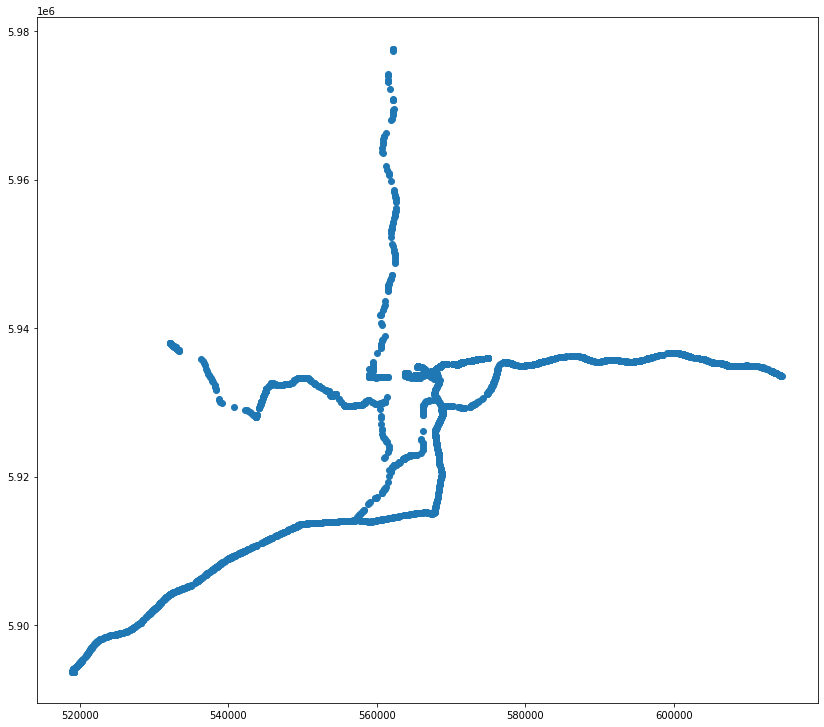

In [26]:
#converting the data frame to goegraphic coordinates and plotting 
neg_gdf_join_osmedge_new.to_crs('EPSG:4326')
neg_gdf_join_osmedge_new.plot(figsize = (14,14))

## Analysing accident data

In [28]:
#reading the accident data from CSV
accident = pd.read_csv('HamburgAccidents.csv', usecols=['UJAHR','UMONAT','USTUNDE', 'UWOCHENTAG', 'UKATEGORIE','XGCSWGS84', 'YGCSWGS84'])
accident

,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,XGCSWGS84,YGCSWGS84
0,2018,5,6,4,3,10.026012,53.551961
1,2018,1,7,3,3,10.040709,53.552636
2,2018,1,18,3,3,10.026115,53.553726
3,2018,1,20,5,3,10.040840,53.552596
4,2018,1,15,4,3,10.040660,53.554326
...,...,...,...,...,...,...,...
7171,2018,9,16,2,3,9.794175,53.515091
7172,2018,9,15,3,2,9.816248,53.513303
7173,2018,4,15,4,3,9.850459,53.508057
7174,2018,5,16,2,3,9.841206,53.511960


In [29]:
#renaming columns of the data
accident['longitude'] = accident['XGCSWGS84']
accident['latitude'] = accident['YGCSWGS84']
accident['year'] = accident['UJAHR']
accident['month'] = accident['UMONAT']
accident['hour'] = accident['USTUNDE']
accident['accident_category'] = accident['UKATEGORIE']
accident['day_of_week'] = accident['UWOCHENTAG']
accident= accident.drop(columns=['XGCSWGS84','YGCSWGS84','UJAHR','UMONAT','USTUNDE','UKATEGORIE','UWOCHENTAG'])
accident

,longitude,latitude,year,month,hour,accident_category,day_of_week
0,10.026012,53.551961,2018,5,6,3,4
1,10.040709,53.552636,2018,1,7,3,3
2,10.026115,53.553726,2018,1,18,3,3
3,10.040840,53.552596,2018,1,20,3,5
4,10.040660,53.554326,2018,1,15,3,4
...,...,...,...,...,...,...,...
7171,9.794175,53.515091,2018,9,16,3,2
7172,9.816248,53.513303,2018,9,15,2,3
7173,9.850459,53.508057,2018,4,15,3,4
7174,9.841206,53.511960,2018,5,16,3,2


In [30]:
#Making a geodataframe of the acident data 
accident_gdf = gpd.GeoDataFrame(
    accident, geometry=gpd.points_from_xy(accident.longitude, accident.latitude),crs="EPSG:4326")

### Hotspot analysis of accidents 

In [31]:
#Grouping accidents by position & category
accident_gdf_category = accident_gdf.groupby(['longitude','latitude'])[['accident_category']].mean().reset_index()
accident_gdf_category.head()

,longitude,latitude,accident_category
0,9.739827,53.585034,3
1,9.745657,53.571408,3
2,9.748869,53.584457,3
3,9.751305,53.583667,3
4,9.751347,53.571374,3


In [48]:
#imoporting the getisOrd function
import getis 

In [33]:
#function to define the color bands
def clr(array):
    col = []
    for value in array:
        if value > 0: 
            col.append('red')
        else:
            col.append('#C2FF00')
    return col

### Mapping Hot & Cold Spots and Overspeeding Points

In [49]:
#plotting the points of overspeeding and hot spots of accident
lats = list(neg_gdf_join_osmedge_new['lat'])
lngs = list(neg_gdf_join_osmedge_new['lng'])
speed = list(neg_gdf_join_osmedge_new['ovrspd']) 
spdlmt = list(neg_gdf_join_osmedge_new['spdlimit'])
def poplt(a,b):
    return('Speed limit is: '+ str(a) +'Km/h' +'\n above limit by:' + str(round(b, 2))+ 'Km/h')

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
ovrspdclr = clr(neg_gdf_join_osmedge_new['ovrspd'])
m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=12)
for lat, lng , col, pop, pop1 in zip(lats,lngs, ovrspdclr, spdlmt, speed):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = poplt(pop, pop1)).add_to(m)
getisacc = getis.getisOrd(accident_gdf_category, value='accident_category', threshold=150, lat='latitude', lng= 'longitude')
getis.map(m, getisacc, value = 'accident_category', style ='hotspots', lat='latitude', lng= 'longitude')
m.save('OverspeedHotColdSpotHamburg.html')

In [35]:
#reprojecting CRS of accident data to projected and buffering by 100m
accident_gdf_proj = accident_gdf.to_crs('EPSG:25832')
accident_gdf_proj['geometry'] = accident_gdf_proj.geometry.buffer(100)
accident_gdf_proj.head()   #output

,longitude,latitude,year,month,hour,accident_category,day_of_week,geometry
0,10.026012,53.551961,2018,5,6,3,4,"POLYGON ((568073.647 5934164.074, 568073.165 5..."
1,10.040709,53.552636,2018,1,7,3,3,"POLYGON ((569046.190 5934253.255, 569045.708 5..."
2,10.026115,53.553726,2018,1,18,3,3,"POLYGON ((568077.615 5934360.529, 568077.134 5..."
3,10.040840,53.552596,2018,1,20,3,5,"POLYGON ((569054.953 5934248.949, 569054.471 5..."
4,10.040660,53.554326,2018,1,15,3,4,"POLYGON ((569040.176 5934441.291, 569039.694 5..."


In [36]:
#Joining FCD with Accident data based on where points intersect in 100m radius
fcd_osm_acc_join = gpd.sjoin(neg_gdf_join_osmedge_new, accident_gdf_proj,how= 'inner', op='intersects')

In [37]:
#exploring the tracks after the join
fcd_osm_acc_join.groupby(fcd_osm_acc_join['track.id']).count()

,lat,lng,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,index_right,longitude,latitude,year_right,month_right,hour,accident_category,day_of_week
track.id,,,,,,,,,,,,,,,,,
53f20f6ee4b0d0547747d58f,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
54f76d4ae4b0bf5f3ce07ee9,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300
54f797c5e4b0bf5f3ce13e1f,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f7987ee4b0bf5f3ce19fbb,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f7996ee4b0bf5f3ce20157,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f79b67e4b0bf5f3ce265d3,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f79cd6e4b0bf5f3ce2e382,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f79df0e4b0bf5f3ce3451e,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
54f79f39e4b0bf5f3ce3a6ba,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234


In [38]:
#points which FCD track is above speed limit by more than 10Km/h and within 100m to an accident point
#please not the temporal frame might not be exact.
fcd_osm_acc_join = fcd_osm_acc_join[fcd_osm_acc_join['ovrspd']>10]
fcd_osm_acc_join

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,index_right,longitude,latitude,year_right,month_right,hour,accident_category,day_of_week
674,575d0172e4b0a69192a77d65,53.451569,10.028949,143.099987,-0.190336,POINT (568329.474 5922998.687),120,2016,5,23.099987,6733,10.029194,53.450820,2018,11,12,3,6
674,575d0172e4b0a69192a77d65,53.451569,10.028949,143.099987,-0.190336,POINT (568329.474 5922998.687),120,2016,5,23.099987,6732,10.028735,53.451474,2018,8,12,3,7
678,575d0172e4b0a69192a77d65,53.458678,10.026913,138.801165,-1.235491,POINT (568182.841 5923787.619),120,2016,5,18.801165,487,10.026823,53.459236,2018,9,13,2,3
682,575d0172e4b0a69192a77d65,53.465429,10.025014,133.200000,-3.600004,POINT (568045.983 5924536.786),120,2016,5,13.200000,500,10.025281,53.464582,2018,5,15,3,5
1504,558ebac4e4b07207d892393f,53.487984,10.029098,113.715898,-3.152527,POINT (568280.897 5927049.810),100,2015,6,13.715898,473,10.028687,53.487363,2018,5,14,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,54f79cd6e4b0bf5f3ce2e382,53.560632,10.071942,64.800000,-5.400000,POINT (571001.917 5935173.524),50,2015,3,14.800000,929,10.071783,53.560546,2018,9,17,3,2
679,54f79df0e4b0bf5f3ce3451e,53.560632,10.071942,64.800000,-5.400000,POINT (571001.917 5935173.524),50,2015,3,14.800000,929,10.071783,53.560546,2018,9,17,3,2
679,54f79f39e4b0bf5f3ce3a6ba,53.560632,10.071942,64.800000,-5.400000,POINT (571001.917 5935173.524),50,2015,3,14.800000,929,10.071783,53.560546,2018,9,17,3,2
679,54f7a028e4b0bf5f3ce40856,53.560632,10.071942,64.800000,-5.400000,POINT (571001.917 5935173.524),50,2015,3,14.800000,929,10.071783,53.560546,2018,9,17,3,2


In [39]:
#renaming join column
fcd_osm_acc_join.rename(
    columns={
        "index_right": "right_index"
    },
    inplace=True
)

### Analysing data for Bars/pubs near accident spots

In [40]:
#reading data of location of pubs and dropping, renaming column not needed
pubs = pd.read_csv('pubshamburg.csv', usecols=['venue.name','venue.location.address','venue.location.lat', 'venue.location.lng'])
pubs['lat'] = pubs['venue.location.lat']
pubs['lng'] = pubs['venue.location.lng']
pubs['name'] = pubs['venue.name']
pubs['address'] = pubs['venue.location.address']
pubs= pubs.drop(columns=['venue.location.lat','venue.location.address','venue.location.lng','venue.name'])
pubs

,lat,lng,name,address
0,53.542455,9.998270,Boilerman Bar,Osakaallee 12
1,53.577759,9.951489,Mr. Ape,Stellinger Weg 9
2,53.550125,9.994436,Le Lion,Rathausstr. 3
3,53.553192,9.958023,Clockers,Paul-Roosen-Str. 27
4,53.558708,9.964224,Zoë II / Sofabar,Neuer Pferdemarkt 17
...,...,...,...,...
95,53.555596,9.962647,The Walrus,Wohlwillstr. 47
96,53.551189,9.957895,STANDARD,NaN
97,53.563091,9.965371,Frank und Frei,Schanzenstr. 93
98,53.585366,9.981245,Cafe & Bar Celona,Lenhartzstr. 1-5


In [41]:
#making a dataframe of pubs csv and projecting to projected CRS & buffer by 500m
pubs_df = gpd.GeoDataFrame(
    pubs, geometry=gpd.points_from_xy(pubs.lng, pubs.lat),crs="EPSG:4326")
pubs_df_proj = pubs_df.to_crs('EPSG:25832')
pubs_df_proj['geometry'] = pubs_df_proj.geometry.buffer(500)

#display output
pubs_df_proj.head()

,lat,lng,name,address,geometry
0,53.542455,9.998270,Boilerman Bar,Osakaallee 12,"POLYGON ((566650.627 5933080.409, 566648.219 5..."
1,53.577759,9.951489,Mr. Ape,Stellinger Weg 9,"POLYGON ((563498.228 5936965.522, 563495.821 5..."
2,53.550125,9.994436,Le Lion,Rathausstr. 3,"POLYGON ((566384.636 5933930.168, 566382.228 5..."
3,53.553192,9.958023,Clockers,Paul-Roosen-Str. 27,"POLYGON ((563967.628 5934238.307, 563965.220 5..."
4,53.558708,9.964224,Zoë II / Sofabar,Neuer Pferdemarkt 17,"POLYGON ((564370.098 5934857.514, 564367.691 5..."


In [42]:
#joining the FCD, ACC & Pubs data based on points they intersect 
fcd_osm_acc_pubs_join = gpd.sjoin(fcd_osm_acc_join,pubs_df_proj,how='inner', op='intersects')
fcd_osm_acc_pubs_join.head()

,track.id,lat_left,lng_left,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,...,year_right,month_right,hour,accident_category,day_of_week,index_right,lat_right,lng_right,name,address
834,575d0172e4b0a69192a77d65,53.554049,10.003897,47.092432,-2.407568,POINT (566505.310 5934375.512),30,2016,5,17.092432,...,2018,4,8,3,5,25,53.554233,9.998983,CIU',Ballindamm 14/15
834,575d0172e4b0a69192a77d65,53.554049,10.003897,47.092432,-2.407568,POINT (566505.310 5934375.512),30,2016,5,17.092432,...,2018,2,12,2,4,25,53.554233,9.998983,CIU',Ballindamm 14/15
30,575d0129e4b0a69192a77bc4,53.554110,10.003533,48.599998,-2.031727,POINT (566481.096 5934381.943),30,2016,5,18.599998,...,2018,2,12,2,4,25,53.554233,9.998983,CIU',Ballindamm 14/15
834,575d0172e4b0a69192a77d65,53.554049,10.003897,47.092432,-2.407568,POINT (566505.310 5934375.512),30,2016,5,17.092432,...,2018,1,17,3,2,25,53.554233,9.998983,CIU',Ballindamm 14/15
30,575d0129e4b0a69192a77bc4,53.554110,10.003533,48.599998,-2.031727,POINT (566481.096 5934381.943),30,2016,5,18.599998,...,2018,1,17,3,2,25,53.554233,9.998983,CIU',Ballindamm 14/15


### Mapping Accidents & Overspeeding points within 1km of a Bar

In [43]:
#displaying output on Map
#Overspeeding points with 500m to a bar/pub:
lats1 = list(fcd_osm_acc_pubs_join['lat_left'])
lngs1 = list(fcd_osm_acc_pubs_join['lng_left'])
overspeed = fcd_osm_acc_pubs_join['ovrspd']
speedlimit = fcd_osm_acc_pubs_join['spdlimit']

#Bars 500m to an accident
lat_pub = list(pubs_df['lat'])
lng_pub = list(pubs_df['lng'])
name = pubs_df['name']
address = pubs_df['address']
avg_lat = sum(lats1) / len(lats1)
avg_lngs = sum(lngs1) / len(lngs1)

#Popup funtion
def popup_acc_func(popa, popb):
    return('Over the limit by: '+ str(round(popa, 2))+ 'Km/h'+'\n The speed limit is:' + str(round(popb, 2))+'Km/h')
def popup_pub_func(popa, popb):
    return('Name: '+ str(popa)+'\n Address:' + str(popb))

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=12)
for lat, lng , pop,pop1 in zip(lats1, lngs1, overspeed, speedlimit):
    folium.CircleMarker([lat, lng], color= 'red' , radius=2.0, popup = popup_acc_func(pop, pop1)).add_to(m)
for lat, lng , pop,pop1 in zip(lat_pub, lng_pub, name, address):
    folium.CircleMarker([lat, lng], color= 'orange' , radius=4.0, popup = popup_pub_func(pop, pop1)).add_to(m)
m.save('OverspedAccidentCloseToPubsHamburg.html')